Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664497_se/CHG_SRX1664497_se.bismark_chr_4.cov.gz
Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664497_se/CpG_SRX1664497_se.bismark_chr_5.cov.gz
Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664497_se/CHG_SRX1664497_se.bismark_chr_5.cov.gz
Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664497_se/CHH_SRX1664497_se.bismark_chr_4.cov.gz
Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664497_se/CpG_SRX1664497_se.bismark_chr_3.cov.gz
Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664497_se/CHH_SRX1664497_se.bismark_chr_2.cov.gz
Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664497_se/CHG_SRX1664497_se.bismark_chr_Mt.cov.gz
Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664497_se/CHG_SRX1664497_se.bismark_chr_2.cov.gz
Processing file: /home/eharpu/methylati

/home/eharpu/data/conda/envs/environment_shannon/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664486_se/CHG_SRX1664486_se.bismark_chr_2.cov.gz
Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664486_se/CHH_SRX1664486_se.bismark_chr_5.cov.gz
Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664486_se/CpG_SRX1664486_se.bismark_chr_4.cov.gz
Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664482_se/CHH_SRX1664482_se.bismark_chr_3.cov.gz
Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664482_se/CpG_SRX1664482_se.bismark_chr_5.cov.gz
Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664482_se/CHH_SRX1664482_se.bismark_chr_Pt.cov.gz
Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664482_se/CpG_SRX1664482_se.bismark_chr_4.cov.gz
Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664482_se/CHG_SRX1664482_se.bismark_chr_3.cov.gz
Processing file: /home/eharpu/methylati

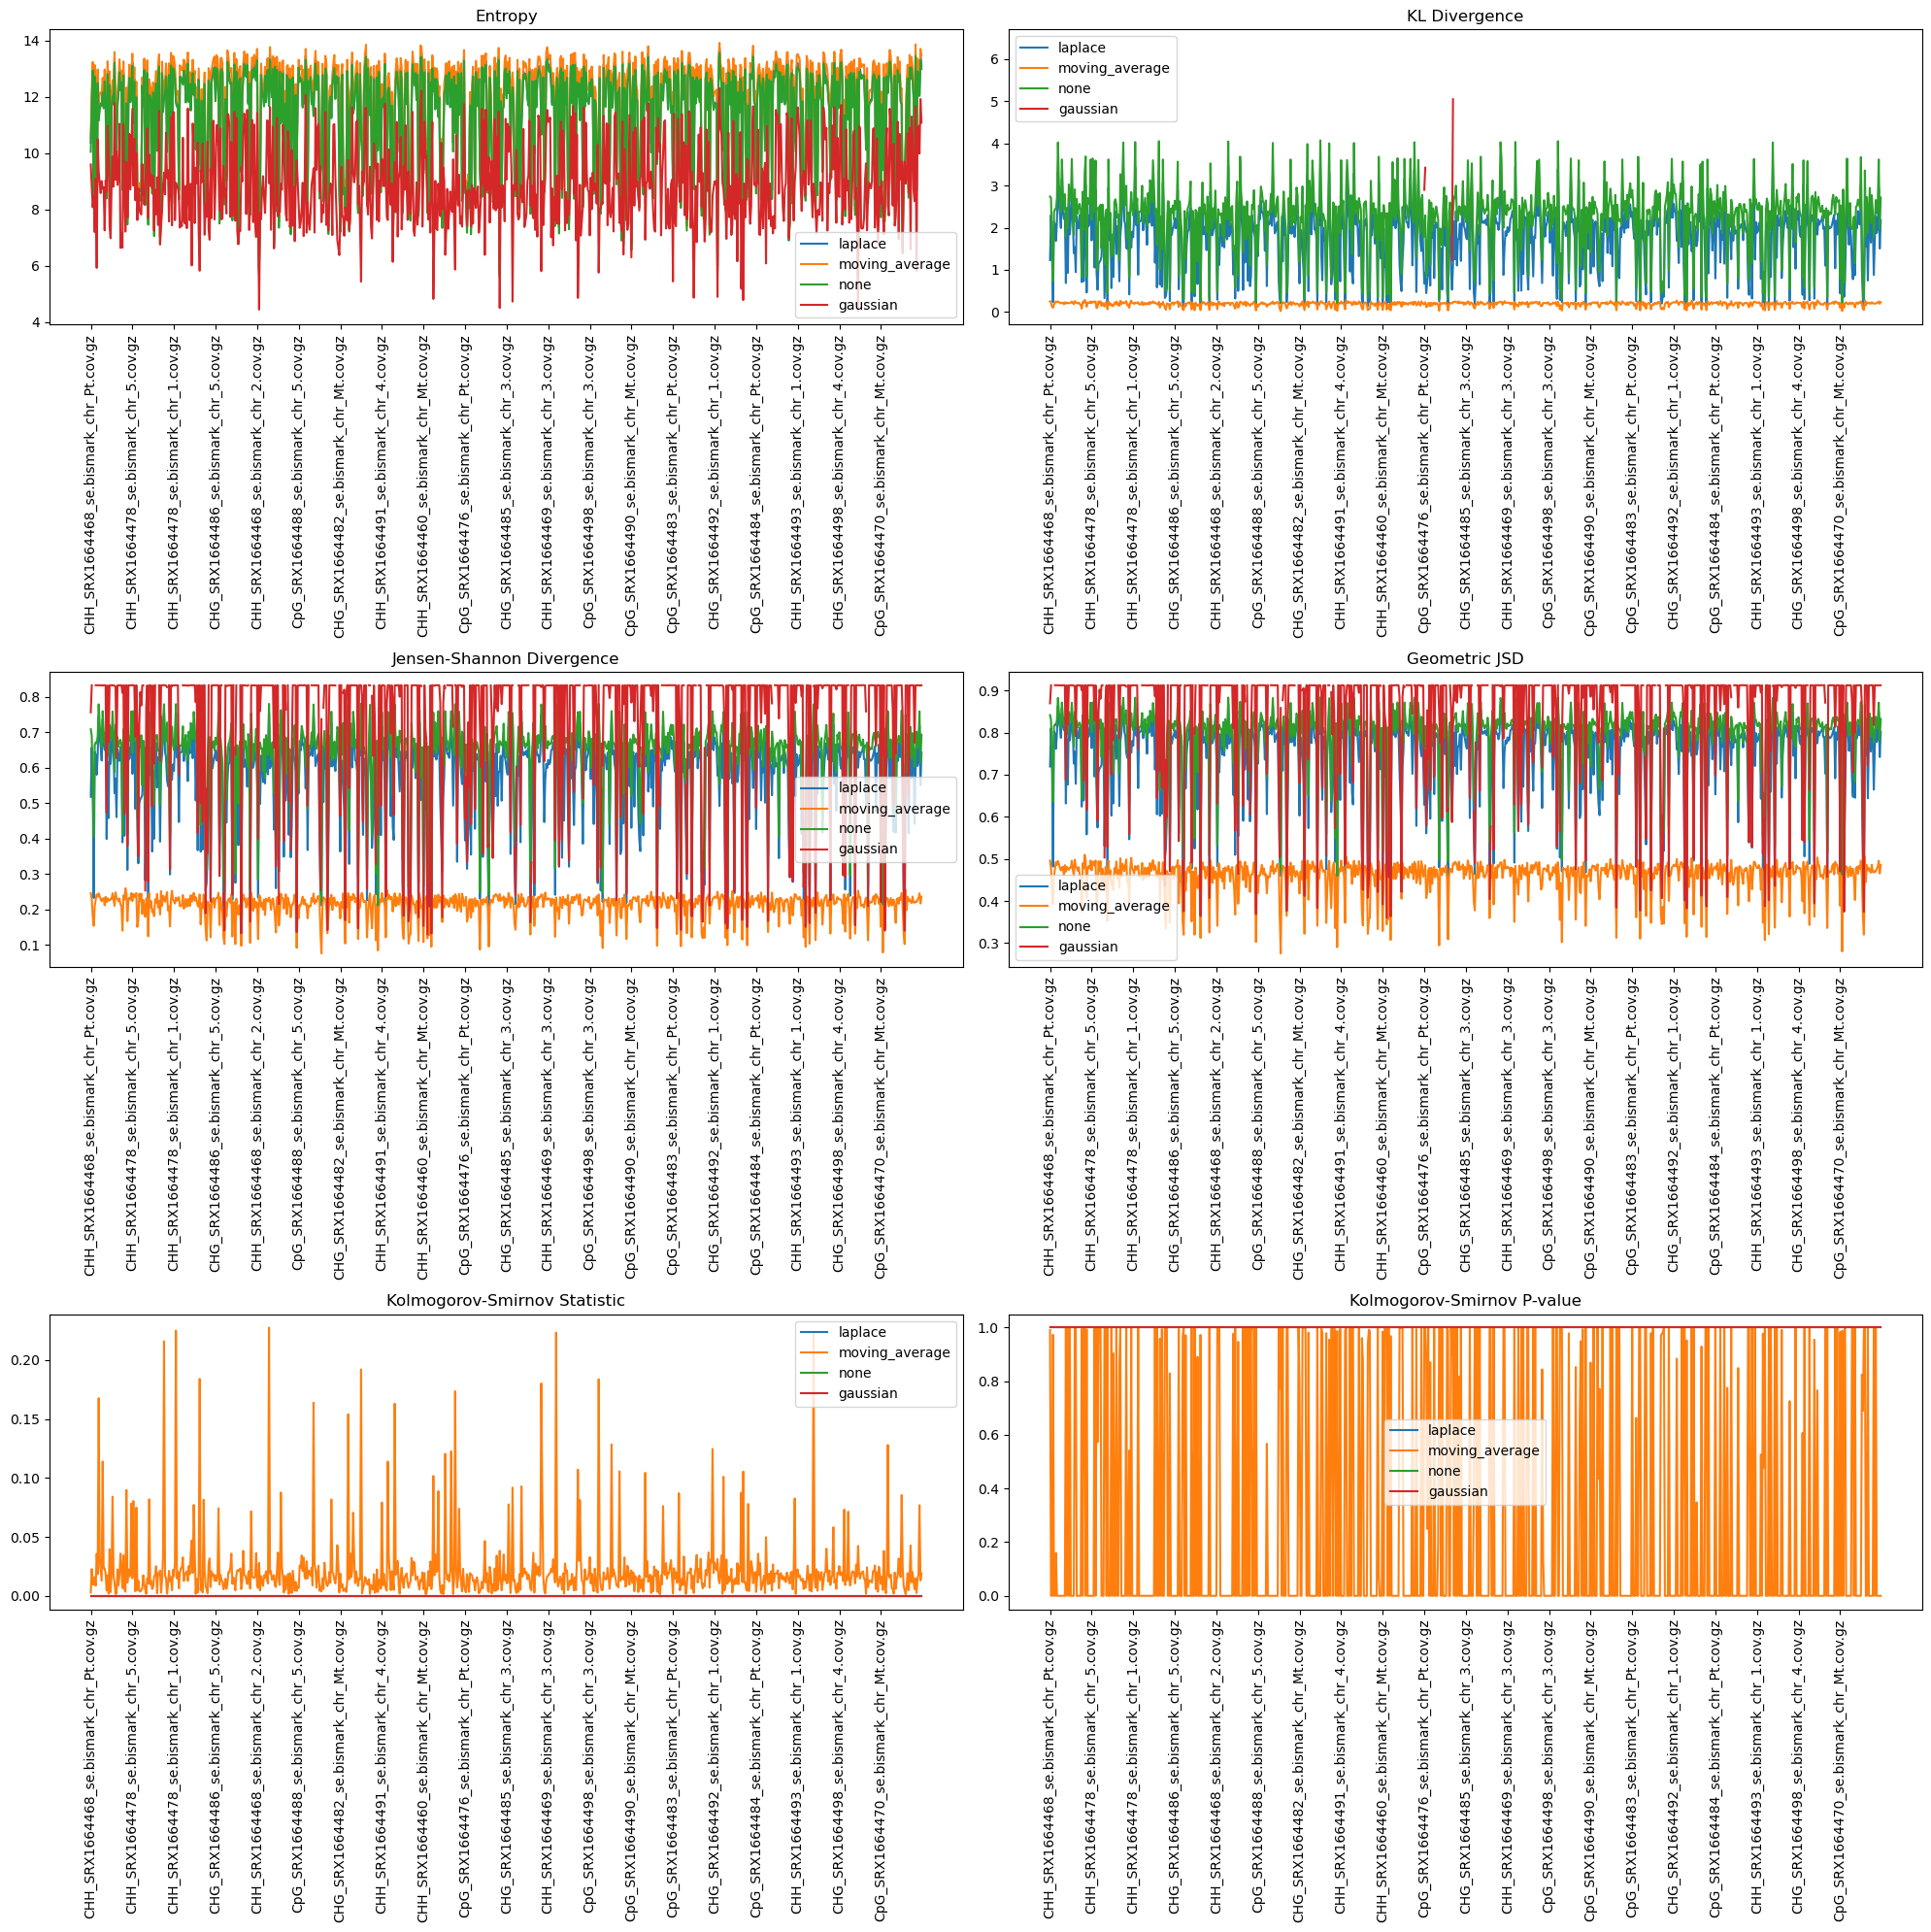

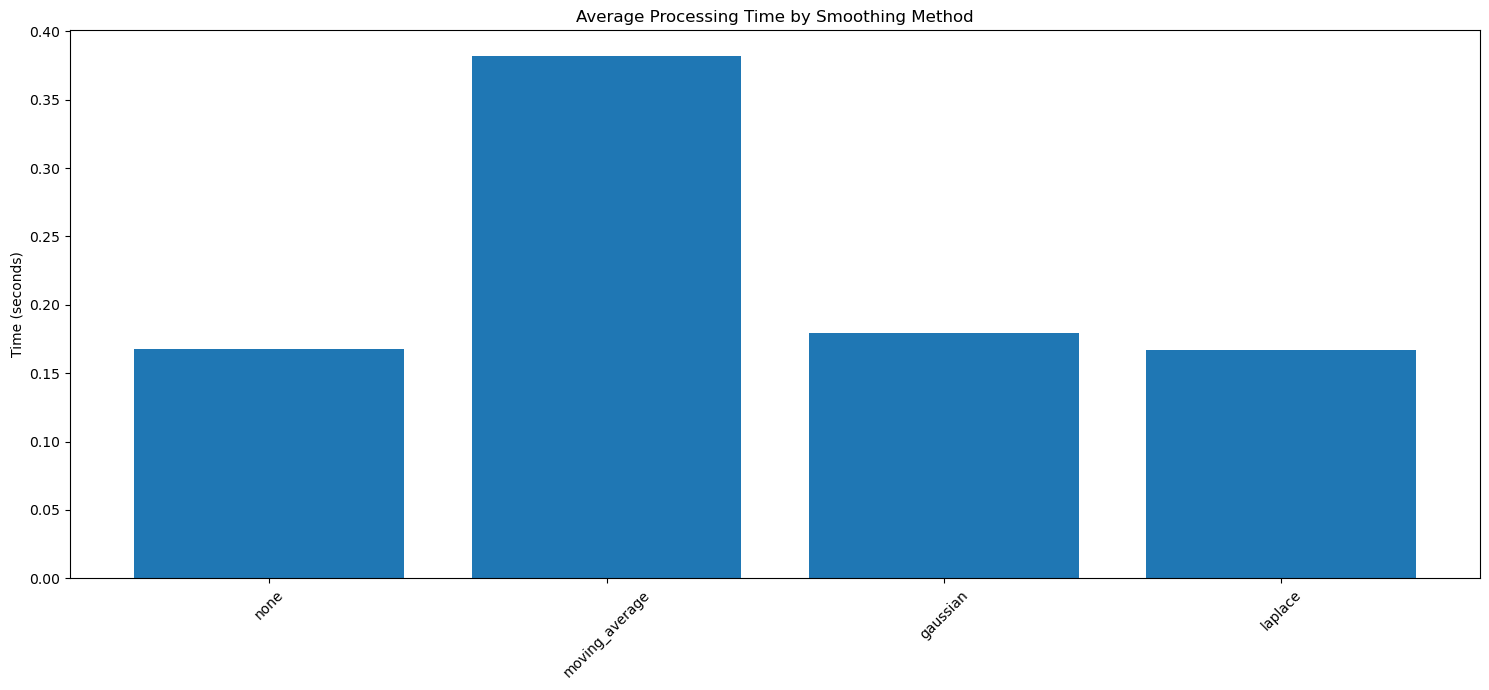

ANOVA test result: F_onewayResult(statistic=159.06723010144054, pvalue=2.1192233833304523e-96)


In [2]:
import pandas as pd
import numpy as np
import os
import gzip
import time
from scipy.stats import entropy, ks_2samp, f_oneway
from scipy.special import rel_entr
from statsmodels.nonparametric.smoothers_lowess import lowess
import zipfile
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import jensenshannon

###################################### Smoothing ########################################

def kl_divergence(p, q):
    return np.sum(rel_entr(p, q))

def geometric_jsd(p, q):
    jsd = jensenshannon(p, q)
    return np.sqrt(jsd)

def ks_test(p, q):
    ks_result = ks_2samp(p, q)
    return ks_result.statistic, ks_result.pvalue

def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def gaussian_smoothing(data, sigma=1):
    return np.exp(-np.square(data - np.mean(data)) / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

def laplace_smoothing(data, alpha=e-10):
    return (data + alpha) / (np.sum(data) + alpha * len(data))

def good_turing_smoothing(data):
    unique, counts = np.unique(data, return_counts=True)
    freq_of_freqs = np.bincount(counts)
    smoothed = np.array([((c+1) * (freq_of_freqs[c+1]/freq_of_freqs[c]) if c+1 < len(freq_of_freqs) else c) for c in counts])
    return smoothed / np.sum(smoothed)

def lowess_smoothing(data, frac=0.3):
    return lowess(data, np.arange(len(data)), frac=frac)[:, 1]

def hmm_smoothing(data, n_components=2):
    model = GaussianMixture(n_components=n_components)
    data_reshaped = data.reshape(-1, 1)
    model.fit(data_reshaped)
    smoothed = model.predict_proba(data_reshaped)[:, 1]
    return smoothed

def apply_smoothing(data, method):
    if method == 'moving_average':
        return moving_average(data)
    elif method == 'gaussian':
        return gaussian_smoothing(data)
    elif method == 'laplace':
        return laplace_smoothing(data)
    elif method == 'good_turing':
        return good_turing_smoothing(data)
    elif method == 'lowess':
        return lowess_smoothing(data)
    elif method == 'hmm':
        return hmm_smoothing(data)
    elif method == 'none':
        return data
    else:
        raise ValueError(f"Unknown smoothing method: {method}")

####################################  Divergence Calculations ########################################

def divergence_calculations(data, each_row=True, smoothing='laplace'):
    results = []

    if each_row:
        for index, row in data.iterrows():
            p = np.array([row['methylated'], row['unmethylated']], dtype=np.float64)
            q = np.array([row['unmethylated'], row['methylated']], dtype=np.float64)
            
            # Filter out zero values
            p = p[p > 0]
            q = q[q > 0]
            
            # Apply smoothing if not 'none'
            if smoothing != 'none':
                p = apply_smoothing(p, smoothing)
                q = apply_smoothing(q, smoothing)
            
            # Normalize p and q
            p /= p.sum()
            q /= q.sum()
            
            kl = kl_divergence(p, q)
            js = jensenshannon(p, q)
            gjs = geometric_jsd(p, q)
            ks_stat, ks_pvalue = ks_test(p, q)

            row_result = {
                'index': index,
                'entropy': entropy(p),
                'relative_entropy': kl,  # KL divergence is relative entropy
                'jsd': js,
                'geometric_jsd': gjs,
                'kolmogorov_smirnov_stat': ks_stat,
                'kolmogorov_smirnov_pvalue': ks_pvalue
            }

            results.append(row_result)

        # Save the results to a CSV file
        results_df = pd.DataFrame(results)
        results_df.to_csv('results.csv', index=False)
        
        # Zip the CSV file
        with zipfile.ZipFile('results.zip', 'w') as zipf:
            zipf.write('results.csv')
        
        # Clean up the CSV file
        os.remove('results.csv')
    else:
        # Calculate the statistics for the entire dataset
        p = data[['methylated', 'unmethylated']].values.flatten().astype(np.float64)
        q = data[['unmethylated', 'methylated']].values.flatten().astype(np.float64)

        # Filter out zero values
        p = p[p > 0]
        q = q[q > 0]

        # Apply smoothing if not 'none'
        if smoothing != 'none':
            p = apply_smoothing(p, smoothing)
            q = apply_smoothing(q, smoothing)

        # Normalize p and q
        p /= p.sum()
        q /= q.sum()

        kl = kl_divergence(p, q)
        js = jensenshannon(p, q)
        gjs = geometric_jsd(p, q)
        ks_stat, ks_pvalue = ks_test(p, q)

        dataset_result = {
            'entropy': entropy(p),
            'relative_entropy': kl,  # KL divergence is relative entropy
            'jsd': js,
            'geometric_jsd': gjs,
            'kolmogorov_smirnov_stat': ks_stat,
            'kolmogorov_smirnov_pvalue': ks_pvalue
        }
        return dataset_result

def process_file(file_path):
    with gzip.open(file_path, 'rt') as f:
        df = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'methylated', 'unmethylated', 'percentage'])
    return df

def analyze_samples(base_dir, smoothing_methods):
    results = {}
    times = {method: [] for method in smoothing_methods}
    
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.cov.gz'):
                file_path = os.path.join(root, file)
                print(f"Processing file: {file_path}")
                data = process_file(file_path)
                
                for method in smoothing_methods:
                    #print(f"Testing method: {method}")
                    start_time = time.time()
                    result = divergence_calculations(data, each_row=False, smoothing=method)
                    end_time = time.time()
                    elapsed_time = end_time - start_time
                    times[method].append(elapsed_time)
                    results[(file, method)] = result
    
    # Save the overall results for different methods to a CSV file
    overall_results_df = pd.DataFrame(results).T
    overall_results_df.to_csv('overall_results.csv', index=True)

    # Zip the overall results CSV file
    zip_file = 'results.zip'
    with zipfile.ZipFile(zip_file, 'w') as zipf:
        zipf.write('overall_results.csv')

    # Clean up the overall results CSV file
    os.remove('overall_results.csv')
    
    return results, times

def plot_results(results, times):
    methods = list(set(key[1] for key in results.keys()))
    files = list(set(key[0] for key in results.keys()))

    entropies = {method: [] for method in methods}
    kl_divergences = {method: [] for method in methods}
    jsds = {method: [] for method in methods}
    geometric_jsds = {method: [] for method in methods}
    ks_statistics = {method: [] for method in methods}
    ks_pvalues = {method: [] for method in methods}

    for file in files:
        for method in methods:
            result = results.get((file, method))
            if result:
                entropies[method].append(result['entropy'])
                kl_divergences[method].append(result['relative_entropy'])
                jsds[method].append(result['jsd'])
                geometric_jsds[method].append(result['geometric_jsd'])
                ks_statistics[method].append(result['kolmogorov_smirnov_stat'])
                ks_pvalues[method].append(result['kolmogorov_smirnov_pvalue'])

    x = np.arange(len(files))

    fig, axs = plt.subplots(3, 2, figsize=(20, 20))  # Increased figure size

    for method in methods:
        axs[0, 0].plot(x, entropies[method], label=method)
        axs[0, 1].plot(x, kl_divergences[method], label=method)
        axs[1, 0].plot(x, jsds[method], label=method)
        axs[1, 1].plot(x, geometric_jsds[method], label=method)
        axs[2, 0].plot(x, ks_statistics[method], label=method)
        axs[2, 1].plot(x, ks_pvalues[method], label=method)

    axs[0, 0].set_title('Entropy')
    axs[0, 1].set_title('KL Divergence')
    axs[1, 0].set_title('Jensen-Shannon Divergence')
    axs[1, 1].set_title('Geometric JSD')
    axs[2, 0].set_title('Kolmogorov-Smirnov Statistic')
    axs[2, 1].set_title('Kolmogorov-Smirnov P-value')

    for ax in axs.flat:
        ax.set_xticks(x[::max(1, len(x)//20)])  # Show a subset of labels to avoid clutter
        ax.set_xticklabels(files[::max(1, len(x)//20)], rotation=90)  # Rotate labels for better readability
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Plotting the times for each method
    fig, ax = plt.subplots(figsize=(15, 7))
    avg_times = {method: np.mean(times[method]) for method in times}
    ax.bar(avg_times.keys(), avg_times.values())
    ax.set_title('Average Processing Time by Smoothing Method')
    ax.set_ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ANOVA test to compare times between different smoothing methods
    time_values = [times[method] for method in times]
    anova_result = f_oneway(*time_values)
    print("ANOVA test result:", anova_result)


# Sample directory path
base_dir = '/home/eharpu/methylation_analysis/samples_testing'
smoothing_methods = ['none', 'moving_average', 'gaussian', 'laplace']
results, times = analyze_samples(base_dir, smoothing_methods)
plot_results(results, times)


In [ ]:
import pandas as pd
import numpy as np
import os
import gzip
import time
from scipy.stats import entropy, ks_2samp, f_oneway
from scipy.special import rel_entr
from statsmodels.nonparametric.smoothers_lowess import lowess
import zipfile
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import jensenshannon

###################################### Smoothing ########################################

def kl_divergence(p, q):
    return np.sum(rel_entr(p, q))

def geometric_jsd(p, q):
    jsd = jensenshannon(p, q)
    return np.sqrt(jsd)

def ks_test(p, q):
    ks_result = ks_2samp(p, q)
    return ks_result.statistic, ks_result.pvalue

def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def gaussian_smoothing(data, sigma=1):
    return np.exp(-np.square(data - np.mean(data)) / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

def laplace_smoothing(data, alpha=1):
    return (data + alpha) / (np.sum(data) + alpha * len(data))

def good_turing_smoothing(data):
    unique, counts = np.unique(data, return_counts=True)
    freq_of_freqs = np.bincount(counts)
    smoothed = np.array([((c+1) * (freq_of_freqs[c+1]/freq_of_freqs[c]) if c+1 < len(freq_of_freqs) else c) for c in counts])
    return smoothed / np.sum(smoothed)

def lowess_smoothing(data, frac=0.3):
    return lowess(data, np.arange(len(data)), frac=frac)[:, 1]

def hmm_smoothing(data, n_components=2):
    model = GaussianMixture(n_components=n_components)
    data_reshaped = data.reshape(-1, 1)
    model.fit(data_reshaped)
    smoothed = model.predict_proba(data_reshaped)[:, 1]
    return smoothed

def apply_smoothing(data, method):
    if method == 'moving_average':
        return moving_average(data)
    elif method == 'gaussian':
        return gaussian_smoothing(data)
    elif method == 'laplace':
        return laplace_smoothing(data)
    elif method == 'good_turing':
        return good_turing_smoothing(data)
    elif method == 'lowess':
        return lowess_smoothing(data)
    elif method == 'hmm':
        return hmm_smoothing(data)
    elif method == 'none':
        return data
    else:
        raise ValueError(f"Unknown smoothing method: {method}")

####################################  Divergence Calculations ########################################

def divergence_calculations(data, each_row=True, smoothing='laplace'):
    results = []

    if each_row:
        for index, row in data.iterrows():
            p = np.array([row['methylated'], row['unmethylated']], dtype=np.float64)
            q = np.array([row['unmethylated'], row['methylated']], dtype=np.float64)
            
            # Filter out zero values
            p = p[p > 0]
            q = q[q > 0]
            
            # Apply smoothing if not 'none'
            if smoothing != 'none':
                p = apply_smoothing(p, smoothing)
                q = apply_smoothing(q, smoothing)
            
            # Normalize p and q
            p /= p.sum()
            q /= q.sum()
            
            kl = kl_divergence(p, q)
            js = jensenshannon(p, q)
            gjs = geometric_jsd(p, q)
            ks_stat, ks_pvalue = ks_test(p, q)

            row_result = {
                'index': index,
                'entropy': entropy(p),
                'relative_entropy': kl,  # KL divergence is relative entropy
                'jsd': js,
                'geometric_jsd': gjs,
                'kolmogorov_smirnov_stat': ks_stat,
                'kolmogorov_smirnov_pvalue': ks_pvalue
            }

            results.append(row_result)

        # Save the results to a CSV file
        results_df = pd.DataFrame(results)
        results_df.to_csv('results.csv', index=False)
        
        # Zip the CSV file
        with zipfile.ZipFile('results.zip', 'w') as zipf:
            zipf.write('results.csv')
        
        # Clean up the CSV file
        os.remove('results.csv')
    else:
        # Calculate the statistics for the entire dataset
        p = data[['methylated', 'unmethylated']].values.flatten().astype(np.float64)
        q = data[['unmethylated', 'methylated']].values.flatten().astype(np.float64)

        # Filter out zero values
        p = p[p > 0]
        q = q[q > 0]

        # Apply smoothing if not 'none'
        if smoothing != 'none':
            p = apply_smoothing(p, smoothing)
            q = apply_smoothing(q, smoothing)

        # Normalize p and q
        p /= p.sum()
        q /= q.sum()

        kl = kl_divergence(p, q)
        js = jensenshannon(p, q)
        gjs = geometric_jsd(p, q)
        ks_stat, ks_pvalue = ks_test(p, q)

        dataset_result = {
            'entropy': entropy(p),
            'relative_entropy': kl,  # KL divergence is relative entropy
            'jsd': js,
            'geometric_jsd': gjs,
            'kolmogorov_smirnov_stat': ks_stat,
            'kolmogorov_smirnov_pvalue': ks_pvalue
        }
        return dataset_result

def process_file(file_path):
    with gzip.open(file_path, 'rt') as f:
        df = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'methylated', 'unmethylated', 'percentage'])
    return df

def analyze_samples(base_dir, smoothing_methods):
    results = {}
    times = {method: [] for method in smoothing_methods}
    
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.cov.gz'):
                file_path = os.path.join(root, file)
                print(f"Processing file: {file_path}")
                data = process_file(file_path)
                
                for method in smoothing_methods:
                    #print(f"Testing method: {method}")
                    start_time = time.time()
                    result = divergence_calculations(data, each_row=False, smoothing=method)
                    end_time = time.time()
                    elapsed_time = end_time - start_time
                    times[method].append(elapsed_time)
                    results[(file, method)] = result
    
    # Save the overall results for different methods to a CSV file
    overall_results_df = pd.DataFrame(results).T
    overall_results_df.to_csv('overall_results.csv', index=True)

    # Zip the overall results CSV file
    zip_file = 'results.zip'
    with zipfile.ZipFile(zip_file, 'w') as zipf:
        zipf.write('overall_results.csv')

    # Clean up the overall results CSV file
    os.remove('overall_results.csv')
    
    return results, times

def plot_results(results, times):
    methods = list(set(key[1] for key in results.keys()))
    files = list(set(key[0] for key in results.keys()))

    entropies = {method: [] for method in methods}
    kl_divergences = {method: [] for method in methods}
    jsds = {method: [] for method in methods}
    geometric_jsds = {method: [] for method in methods}
    ks_statistics = {method: [] for method in methods}
    ks_pvalues = {method: [] for method in methods}

    for file in files:
        for method in methods:
            result = results.get((file, method))
            if result:
                entropies[method].append(result['entropy'])
                kl_divergences[method].append(result['relative_entropy'])
                jsds[method].append(result['jsd'])
                geometric_jsds[method].append(result['geometric_jsd'])
                ks_statistics[method].append(result['kolmogorov_smirnov_stat'])
                ks_pvalues[method].append(result['kolmogorov_smirnov_pvalue'])

    x = np.arange(len(files))

    fig, axs = plt.subplots(3, 2, figsize=(20, 20))  # Increased figure size

    for method in methods:
        axs[0, 0].plot(x, entropies[method], label=method)
        axs[0, 1].plot(x, kl_divergences[method], label=method)
        axs[1, 0].plot(x, jsds[method], label=method)
        axs[1, 1].plot(x, geometric_jsds[method], label=method)
        axs[2, 0].plot(x, ks_statistics[method], label=method)
        axs[2, 1].plot(x, ks_pvalues[method], label=method)

    axs[0, 0].set_title('Entropy')
    axs[0, 1].set_title('KL Divergence')
    axs[1, 0].set_title('Jensen-Shannon Divergence')
    axs[1, 1].set_title('Geometric JSD')
    axs[2, 0].set_title('Kolmogorov-Smirnov Statistic')
    axs[2, 1].set_title('Kolmogorov-Smirnov P-value')

    for ax in axs.flat:
        ax.set_xticks(x[::max(1, len(x)//20)])  # Show a subset of labels to avoid clutter
        ax.set_xticklabels(files[::max(1, len(x)//20)], rotation=90)  # Rotate labels for better readability
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Plotting the times for each method
    fig, ax = plt.subplots(figsize=(15, 7))
    avg_times = {method: np.mean(times[method]) for method in times}
    ax.bar(avg_times.keys(), avg_times.values())
    ax.set_title('Average Processing Time by Smoothing Method')
    ax.set_ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ANOVA test to compare times between different smoothing methods
    time_values = [times[method] for method in times]
    anova_result = f_oneway(*time_values)
    print("ANOVA test result:", anova_result)


# Sample directory path
base_dir = '/home/eharpu/methylation_analysis/samples_testing'
smoothing_methods = ['hmm', 'lowess']
results, times = analyze_samples(base_dir, smoothing_methods)
plot_results(results, times)


Processing file: /home/eharpu/methylation_analysis/samples_testing/SRX1664497_se/CHG_SRX1664497_se.bismark_chr_4.cov.gz
